In [1]:
import asreview as asr

from asreview.models.balancers import Balanced
from asreview.models.queriers import Max

from asreview.models.classifiers import SVM
from asreviewcontrib.dory.classifiers.neural_networks import DynamicNNClassifier  # noqa:F401
from asreviewcontrib.dory.feature_extractors.transformer_embeddings import MXBAI

from sklearn.decomposition import NMF
from cockatiel.cockatiel.sampling import ScipySobolSequence
from cockatiel.cockatiel.sobol import SobolEstimator  # JansenEstimator
import matplotlib.pyplot as plt
import random

import numpy as np
import pandas as pd
from dataclasses import dataclass, field
import os

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from collections import Counter
import re

nltk.download(info_or_id="punkt_tab")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

2025-06-25 10:01:46,870 SequenceTagger predicts: Dictionary with 47 tags: O, S-NP, B-NP, E-NP, I-NP, S-VP, B-VP, E-VP, I-VP, S-PP, B-PP, E-PP, I-PP, S-ADVP, B-ADVP, E-ADVP, I-ADVP, S-SBAR, B-SBAR, E-SBAR, I-SBAR, S-ADJP, B-ADJP, E-ADJP, I-ADJP, S-PRT, B-PRT, E-PRT, I-PRT, S-CONJP, B-CONJP, E-CONJP, I-CONJP, S-INTJ, B-INTJ, E-INTJ, I-INTJ, S-LST, B-LST, E-LST, I-LST, S-UCP, B-UCP, E-UCP, I-UCP, <START>, <STOP>


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\5927226\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\5927226\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\5927226\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\5927226\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset = "Jeyaraman_2020"

data = asr.load_dataset(f"data/{dataset}.csv")

alc = asr.ActiveLearningCycle(
    # classifier=DynamicNNClassifier(),
    classifier=SVM(max_iter=5000, loss="squared_hinge", C=0.067),  # classifier c(x)
    feature_extractor=MXBAI(normalize=False),
    balancer=Balanced(ratio=9.724),
    querier=Max(),
)

In [3]:
embedding_path = f"data/{dataset}_embedding_matrix.pkl"

if not os.path.exists(embedding_path):
    embedding_matrix = alc.transform(data)
    pd.DataFrame(embedding_matrix).to_pickle(embedding_path)
    embedding_matrix = np.array(embedding_matrix)
else:
    embedding_matrix = pd.read_pickle(embedding_path)
    embedding_matrix = np.array(embedding_matrix)


In [4]:
def normalize_embedding(fm) -> np.ndarray:
    return (fm - fm.min()) / (fm.max() - fm.min())


@dataclass
class EmbeddingNormalizer:
    base_embedding: np.ndarray
    embedding_min: float = field(init=False)
    embedding_max: float = field(init=False)

    def __post_init__(self):
        self.embedding_min = float(self.base_embedding.min())
        self.embedding_max = float(self.base_embedding.max())

    def normalize(self, embedding) -> np.ndarray:
        return (embedding - self.embedding_min) / (
            self.embedding_max - self.embedding_min
        )


embedding_normalizer = EmbeddingNormalizer(embedding_matrix)

normalized_embedding_matrix: np.ndarray = embedding_normalizer.normalize(
    embedding_matrix
)

In [5]:
data["included"][data["included"] == 1]

6       1
19      1
25      1
30      1
34      1
       ..
1137    1
1138    1
1150    1
1155    1
1159    1
Name: included, Length: 96, dtype: int64

In [6]:
simulate = asr.Simulate(  # c(A) in the cycler
    X=normalized_embedding_matrix,
    labels=list(data["included"]),
    cycles=[alc],
    skip_transform=True,
)

simulate.label(list(range(70)))
simulate.review()

Relevant records found:   6%|▋         | 6/96 [00:00<?, ?it/s]

Records labeled       :  83%|████████▎ | 971/1175 [10:01<02:16,  1.50it/s]


Loss: 0.106
NDCG: 0.734


In [7]:
def get_proba_from_cycle(X: np.ndarray, simulate: asr.Simulate = simulate):
    try:
        proba = simulate.cycles[0].classifier.predict_proba(X)
        return proba

    except AttributeError:
        try:
            scores = simulate.cycles[0].classifier.decision_function(X).reshape(-1, 1)
            pos = np.maximum(scores, 0.0).reshape(-1, 1)
            neg = np.maximum(-scores, 0.0).reshape(-1, 1)
            return np.hstack([neg, pos])

        except AttributeError:
            raise AttributeError(
                "Not possible to compute probabilities or "
                "decision function for this classifier."
            )

# Cockatiel - positive

In [8]:
class JansenEstimator(SobolEstimator):
    def __call__(self, masks, outputs, nb_design):
        nb_dim = self.masks_dim(masks)
        sampling_a, _, replication_c = self.split_abc(outputs, nb_design, nb_dim)
        mu_a = np.mean(sampling_a)
        var = np.sum([(v - mu_a) ** 2 for v in sampling_a]) / (len(sampling_a) - 1)
        eps = 1e-12
        if var < eps:
            return np.zeros(nb_dim)
        stis = [
            np.sum((sampling_a - replication_c[i]) ** 2.0) / (2 * nb_design * var)
            for i in range(nb_dim)
        ]
        return self.post_process(stis, masks)


def sobol_importance(
    activations: np.ndarray,
    class_id: int,
    W: np.ndarray,
    components: int,
):
    sobol_nb_design: int = 64
    n_samples = activations.shape[0]
    masks = ScipySobolSequence()(components, nb_design=sobol_nb_design)
    estimator = JansenEstimator()

    importances = []

    for i in range(n_samples):
        act = activations[i]

        perturbation = masks @ W
        perturbated_activations = act[None, :] + perturbation * act[None, :]
        y_pred = get_proba_from_cycle(perturbated_activations)[:, class_id]

        stis = estimator(masks, y_pred, sobol_nb_design)
        importances.append(stis)

    global_importance = np.mean(importances, axis=0)

    return global_importance

In [9]:
labels = np.array(simulate.labels)

pos_normalized_embedding_matrix = normalized_embedding_matrix[labels == 1]

In [10]:
pos_normalized_embedding_matrix

array([[0.34919026, 0.32492265, 0.36663657, ..., 0.2415339 , 0.4142358 ,
        0.24710934],
       [0.37908027, 0.3849073 , 0.3318827 , ..., 0.26922914, 0.44161862,
        0.32187974],
       [0.321627  , 0.3621015 , 0.28374538, ..., 0.2803836 , 0.35514003,
        0.24321696],
       ...,
       [0.33679834, 0.33103365, 0.40021113, ..., 0.29304478, 0.38977936,
        0.29618937],
       [0.3360047 , 0.44705084, 0.31795424, ..., 0.2670265 , 0.42930007,
        0.24695331],
       [0.39864662, 0.36148745, 0.30598298, ..., 0.2686358 , 0.4188304 ,
        0.25355652]], shape=(96, 1024), dtype=float32)

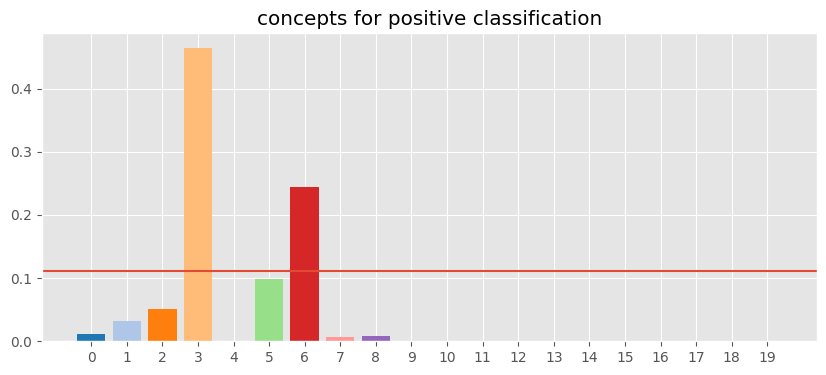

In [52]:
# Do the NMF
factorization = NMF(n_components=20, max_iter=10000)

# Fit the NMF model to the positive normalized embedding matrix
u_matrix: np.ndarray = factorization.fit_transform(
    pos_normalized_embedding_matrix
)  # concept coefficient matrix
w_matrix: np.ndarray = factorization.components_  # concept base matrix

# Compute the concept importance using Sobol's method
pos_concept_importance = sobol_importance(
    activations=pos_normalized_embedding_matrix,
    class_id=1,
    W=w_matrix,
    components=factorization.n_components,
)

# Plot the results
plt.figure(figsize=(22, 4))

plt.subplot(122)
plt.bar(
    range(len(pos_concept_importance)),
    pos_concept_importance,
    color=plt.get_cmap("tab20").colors,
    tick_label=range(len(pos_concept_importance)),
)
plt.axhline(pos_concept_importance.std())
plt.title("concepts for positive classification")

plt.show()

In [53]:
# finding abstracts that align with concepts
df = data.get_df()[["title", "abstract"]]

# pos only
df = df[labels == 1]

# use the text merger part of the feature extractor to get the text column
df["text"] = (
    simulate.cycles[0]
    .feature_extractor.steps[0][1]
    .transform(df[["title", "abstract"]])
)

df["u"] = list(u_matrix)

df["a"] = list(pos_normalized_embedding_matrix)

df.head(4)

,title,abstract,text,u,a
6,Weight-Bearing Compared with Non-Weight-Bearin...,Patients are routinely kept non-weight-bearing...,Weight-Bearing Compared with Non-Weight-Bearin...,"[0.021768222, 0.004579915, 0.0, 0.0, 0.0144047...","[0.34919026, 0.32492265, 0.36663657, 0.4886208..."
19,Injectable Cultured Bone Marrow–Derived Mesenc...,To analyze the results of the use of intra-art...,Injectable Cultured Bone Marrow–Derived Mesenc...,"[0.0023253625, 0.014292329, 0.0017464877, 0.00...","[0.37908027, 0.3849073, 0.3318827, 0.41122133,..."
25,Unicompartmental osteoarthritis: an integrated...,Although traditionally not indicated for the t...,Unicompartmental osteoarthritis: an integrated...,"[0.0, 0.01651517, 0.00044277697, 0.0033190378,...","[0.321627, 0.3621015, 0.28374538, 0.41755384, ..."
30,Matrix-Augmented Bone Marrow Stimulation With ...,Microfracture (MF) is an established operative...,Matrix-Augmented Bone Marrow Stimulation With ...,"[0.020149829, 0.019687638, 0.0, 0.0026836228, ...","[0.39255202, 0.38030633, 0.31288335, 0.5088419..."


## Concept-Aligned Abstract Selection

The following code selects abstracts aligned with important concepts for each class. This is intended to support the visualization of concept-based occlusion as done in the COCKATIEL paper.

In the paper, the authors describe this step as:

    “We take the first n most important sentences for each concept looked at.”

However, this wording is misleading.

What the code actually does:

    It first identifies the top-m most important concepts for each class (m_cls_0 and m_cls_1) using the Sobol importance scores.

    Then, for each of these top concepts, it selects the n abstracts from the corresponding class (0 or 1) that have the highest activation for that concept (i.e., the highest coefficient in the NMF U matrix).

    The result is a list of m × n abstracts per class that best represent the most influential concepts, according to NMF.

The abstracts are not ranked globally by importance or fidelity to the model’s prediction.
Instead, they are selected per concept, based on how strongly each abstract activates that concept.

In [54]:
len(df)

96

In [55]:
threshold = np.std(pos_concept_importance)
top_cids = np.where(pos_concept_importance > threshold)[0]

print(f"Selected {len(top_cids)} concepts")

rows = []
for cid in top_cids:
    best_ids = np.argsort(u_matrix[:, cid])[::-1][
        : round(len(df) / (2 * len(top_cids)))
    ]
    for i in best_ids:
        rows.append({"text": df.iloc[i]["text"], "concept_id": cid})

df_top_abs = pd.DataFrame(data=rows)


Selected 2 concepts


# Occlusion

In [56]:
simulate.cycles[0].feature_extractor.steps[1][1].verbose = False


def occlude_concepts(
    row,
    concept_ids,
    simulate=simulate,
    factorization=factorization,
) -> pd.DataFrame:
    sentences = sent_tokenize(row["text"])

    perturbed_texts = [
        " ".join(s for j, s in enumerate(sentences) if j != i)
        for i in range(len(sentences))
    ]

    # only use the transformer, not the text merger
    A_occluded = (
        simulate.cycles[0].feature_extractor.steps[1][1].fit_transform(perturbed_texts)
    )

    # Normalize using original min and max values, not the new ones!
    A_norm = embedding_normalizer.normalize(embedding=A_occluded)

    # project the whole batch to concept space
    U_occ = factorization.transform(A_norm)

    # ∆U: full – perturbed  (broadcasts row['u'])
    delta = row["u"] - U_occ

    # Only keep the columns for the selected concept_ids
    concept_cols = [f"concept_{i}" for i in concept_ids]
    delta_selected = delta[:, concept_ids]

    # normalize using the method cockatiel uses
    delta_selected /= np.max(np.abs(delta_selected)) + 1e-5

    delta_selected = np.clip(delta_selected, 0, 1)

    out = pd.DataFrame(delta_selected, columns=concept_cols)
    out.insert(0, "sentence", sentences)

    return out

## Visualization

In [57]:
from IPython.core.display import HTML

colors = np.array(
    [
        "rgba(9, 221, 55, ",  # green
        "rgba(9, 175, 221, ",  # blue
        "rgba(9, 34, 221, ",  # purple
        "rgba(221, 90, 9, ",  # orange
        "rgba(221, 9, 34, ",  # red
        "rgba(221, 9, 140,",  # pink
        "rgba(9, 221, 161, ",  # turquoise
    ]
)


def visualize_concepts(df: pd.DataFrame, threshold=0.2):
    html = []

    concept_ids = df.columns[1:]

    for i, concept_id in enumerate(concept_ids):
        html.append(
            f'<span style="background-color: {colors[i]} 0.5); margin: 7px; padding: 1px 5px; border: solid 3px ; border-color: {colors[i]} 1); #EFEFEF">{concept_id} </span>'
        )
    display(
        HTML(
            "<div style='display: flex; width: 400px; flex-wrap: wrap;'>"
            + " ".join(html)
            + " </div>"
        )
    )

    html = []

    # Sentence-level highlighting
    for _, row in df.iterrows():
        sentence = row["sentence"]
        phi_vals = [row[cid] for cid in concept_ids]
        k = np.argmax(phi_vals)
        max_phi = phi_vals[k]
        if max_phi > threshold:
            html.append(
                f'<span style="display: inline; background-color: {colors[k]} {max_phi}); padding: 1px 5px; border: solid 3px ; border-color: {colors[k]} 1); #EFEFEF">{sentence}</span>'
            )
        else:
            html.append(
                f'<span style="display: inline; background-color: rgba(0, 0, 0, 0.0); padding: 1px 5px; border: solid 3px ; border-color: rgba(0, 0, 0, 0.0); #EFEFEF">{sentence}</span>'
            )
    display(
        HTML(
            "<div style='display: flex; width: 800px; flex-wrap: wrap;'>"
            + "".join(html)
            + " </div>"
        )
    )

In [58]:
ps = PorterStemmer()
top_words_per_concept = {}

for concept in top_cids:
    texts = df_top_abs[df_top_abs["concept_id"] == concept].text
    words = []
    for t in texts:
        words += [
            #ps.stem(w)
            w
            for w in re.findall(r"\b\w+\b", t.lower())
            if w not in stop_words and not w.isdigit()
        ]
    counter = Counter(words)
    top_words = [w for w, _ in counter.most_common(20)]
    top_words_per_concept[concept] = top_words

df_top_words_wide = pd.DataFrame(top_words_per_concept)

df_top_words_wide


,3,6
0,group,cartilage
1,cartilage,p
2,patients,patients
3,knee,years
4,clinical,knee
5,p,group
6,treatment,clinical
7,outcomes,score
8,bone,follow
9,follow,repair


In [ ]:
for record_id in range(50):
    print(f"{record_id = }")
    alignment = occlude_concepts(df.iloc[record_id], top_cids)
    visualize_concepts(alignment, 0.2)

record_id = 0


record_id = 1


record_id = 2


record_id = 3


record_id = 4


record_id = 5


record_id = 6


record_id = 7


record_id = 8


record_id = 9


record_id = 10


record_id = 11


record_id = 12


record_id = 13


record_id = 14


record_id = 15


record_id = 16


record_id = 17


record_id = 18


record_id = 19


record_id = 20


record_id = 21


record_id = 22


record_id = 23


record_id = 24


record_id = 25


record_id = 26


record_id = 27


record_id = 28


record_id = 29


record_id = 30


record_id = 31


record_id = 32


record_id = 33


record_id = 34


record_id = 35


record_id = 36


record_id = 37


record_id = 38


record_id = 39


<div style='display: flex; width: 800px; flex-wrap: wrap; font-size: 14px;'><span style="display: inline; background-color: rgba(9, 221, 55,  0.7380246520042419); padding: 1px 5px; border: solid 3px ; border-color: rgba(9, 221, 55,  1); #EFEFEF">Comparative Clinical Observation of Arthroscopic Microfracture in the Presence and Absence of a Stromal Vascular Fraction Injection for Osteoarthritis Abstract Osteoarthritis (OA) is a degenerative cartilage disease that is characterized by a local inflammatory reaction.</span><span style="display: inline; background-color: rgba(9, 221, 161,  0.4463752508163452); padding: 1px 5px; border: solid 3px ; border-color: rgba(9, 221, 161,  1); #EFEFEF">Consequently, many studies have been performed to identify suitable prevention and treatment interventions.</span><span style="display: inline; background-color: rgba(9, 221, 55,  0.9877069592475891); padding: 1px 5px; border: solid 3px ; border-color: rgba(9, 221, 55,  1); #EFEFEF">In recent years, both arthroscopic microfracture (AM) and stem cell therapy have been used clinically to treat OA.</span><span style="display: inline; background-color: rgba(0, 0, 0, 0); padding: 1px 5px; border: solid 3px ; border-color: rgba(0, 0, 0, 0); #EFEFEF">This study aimed to evaluate the clinical effects of AM in the presence and absence of a stromal vascular fraction (SVF) injection in the management of patients with OA.</span><span style="display: inline; background-color: rgba(9, 221, 55,  0.2114211767911911); padding: 1px 5px; border: solid 3px ; border-color: rgba(9, 221, 55,  1); #EFEFEF">Thirty patients with grade 2 or 3 (Lawrence scale) OA of the knee participated in this study.</span><span style="display: inline; background-color: rgba(0, 0, 0, 0); padding: 1px 5px; border: solid 3px ; border-color: rgba(0, 0, 0, 0); #EFEFEF">Placebo group patients (n = 15) received AM alone; treatment group patients (n = 15) received AM and an adipose tissue-derived SVF injection.</span><span style="display: inline; background-color: rgba(9, 221, 55,  0.31701868772506714); padding: 1px 5px; border: solid 3px ; border-color: rgba(9, 221, 55,  1); #EFEFEF">The SVF was suspended in platelet-rich plasma (PRP) before injection into the joint.</span><span style="display: inline; background-color: rgba(0, 0, 0, 0); padding: 1px 5px; border: solid 3px ; border-color: rgba(0, 0, 0, 0); #EFEFEF">Patient groups were monitored and scored with the Western Ontario and McMaster Universities Arthritis Index (WOMAC), Lysholm, Visual Analog Pain Scale (VAS), and modified Outerbridge classifications before treatment and at 6, 12, and 18 months post-treatment.</span><span style="display: inline; background-color: rgba(0, 0, 0, 0); padding: 1px 5px; border: solid 3px ; border-color: rgba(0, 0, 0, 0); #EFEFEF">Bone marrow edema was also assessed at these time points.</span><span style="display: inline; background-color: rgba(0, 0, 0, 0); padding: 1px 5px; border: solid 3px ; border-color: rgba(0, 0, 0, 0); #EFEFEF">Patients were evaluated for knee activity (joint motion amplitude) and adverse effects relating to surgery and stem cell injection.</span><span style="display: inline; background-color: rgba(0, 0, 0, 0); padding: 1px 5px; border: solid 3px ; border-color: rgba(0, 0, 0, 0); #EFEFEF">Treatment efficacy was significantly different between placebo and treatment groups.</span><span style="display: inline; background-color: rgba(9, 221, 161,  0.2329147607088089); padding: 1px 5px; border: solid 3px ; border-color: rgba(9, 221, 161,  1); #EFEFEF">All treatment group patients had significantly reduced pain and WOMAC scores, and increased Lysholm and VAS scores compared with the placebo group.</span><span style="display: inline; background-color: rgba(9, 221, 161,  0.31319883465766907); padding: 1px 5px; border: solid 3px ; border-color: rgba(9, 221, 161,  1); #EFEFEF">These findings suggest that the SVF/PRP injection efficiently improved OA for 18 months after treatment.</span><span style="display: inline; background-color: rgba(0, 0, 0, 0); padding: 1px 5px; border: solid 3px ; border-color: rgba(0, 0, 0, 0); #EFEFEF">This study will be continuously monitored for additional 24 months.</span> </div>